In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PCG Model

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Train_pcg_X.csv')
y_train = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Train_pcg_y.csv')
X_test = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Test_pcg_X.csv')
y_test = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Test_pcg_y.csv')

X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

# Reset index
X_combined.reset_index(drop=True, inplace=True)
y_combined.reset_index(drop=True, inplace=True)

In [ ]:
X_combined.head()

,MEAN,STD,ENERGY,POWER,AE_MEDIAN,RM_MIN,ZCR_GLOBAL,ZCR_MAX,PEAK_AMP,PEAK_FREQ,...,DELTA1_STD,DELTA2_MEAN,DELTA2_MEDIAN,CA_MEAN,CA_MEDIAN,CD_MIN,CD_MEAN,CD_MEDIAN,CD_STD,ZCR_MIN
0,0.430983,0.596186,0.382384,0.382384,0.467531,0.353035,0.793099,0.742194,0.365551,0.304578,...,0.456553,0.550458,0.417596,0.430924,0.399806,0.539056,0.052427,0.247277,0.301989,NaN
1,0.156740,0.428703,0.206853,0.206853,0.357176,0.404880,0.525813,0.680350,0.201159,0.876830,...,0.141529,0.592429,0.710600,0.156739,0.396336,0.962503,0.607633,0.908707,0.076848,NaN
2,0.519970,0.841029,0.723337,0.723337,0.666721,0.438871,0.197395,0.463302,0.881168,0.017284,...,0.266773,0.951635,0.447793,0.519897,0.240157,0.677959,0.091123,0.414842,0.169974,NaN
3,0.161902,0.574294,0.356781,0.356781,0.523935,0.639725,0.272078,0.445465,0.658242,0.104329,...,0.204326,0.661746,0.751349,0.161890,0.496905,0.000000,0.000000,0.933619,0.231633,NaN
4,0.475599,0.285268,0.093754,0.093754,0.241327,0.178963,0.534147,0.599508,0.034359,0.444254,...,0.196865,0.483854,0.288845,0.475592,0.392074,0.658072,0.719466,0.500538,0.026418,NaN


In [ ]:
X_combined.columns

Index(['MEAN', 'STD', 'ENERGY', 'POWER', 'AE_MEDIAN', 'RM_MIN', 'ZCR_GLOBAL',
       'ZCR_MAX', 'PEAK_AMP', 'PEAK_FREQ', 'BER_MIN', 'SB_MAX', 'SB_MEAN',
       'SB_STD', 'MFCC_MAX', 'MFCC_MEDIAN', 'DELTA1_MIN', 'DELTA1_MEAN',
       'DELTA1_MEDIAN', 'DELTA1_STD', 'DELTA2_MEAN', 'DELTA2_MEDIAN',
       'CA_MEAN', 'CA_MEDIAN', 'CD_MIN', 'CD_MEAN', 'CD_MEDIAN', 'CD_STD',
       'ZCR_MIN'],
      dtype='object')

In [ ]:
# Sequential Forward Selection
sfs = SFS(RandomForestClassifier(n_estimators=100, random_state=42),
          k_features=7)
sfs = sfs.fit(X_combined, y_combined.values.ravel())
sfs.k_feature_names_

('MEAN', 'STD', 'AE_MEDIAN', 'PEAK_FREQ', 'SB_MEAN', 'MFCC_MEDIAN', 'CD_MEAN')

In [ ]:
# Sequential Backward Selection
SBS = SFS(RandomForestClassifier(n_estimators=100, random_state=42),
          k_features=7, forward = False)
SBS = SBS.fit(X_combined, y_combined.values.ravel())
SBS.k_feature_names_

('ENERGY',
 'PEAK_AMP',
 'PEAK_FREQ',
 'DELTA1_MEDIAN',
 'DELTA2_MEAN',
 'CA_MEAN',
 'CD_MEAN')

In [ ]:
# Use only selected features
selected_features =  ['MEAN', 'RM_MIN', 'ZCR_GLOBAL', 'PEAK_AMP', 'SB_MEAN', 'CA_MEAN', 'CD_MEDIAN']
X_combined = X_combined[selected_features]

# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y_combined)  # REST, Medium, HIGH -> 0,1,2

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Define models
models = {
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

# Define hyperparameter grids
param_grids = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': [3, 5, 7]}
}

# Loop through models and perform Grid Search
best_params = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_combined, y_combined.values.ravel())
    best_params[model_name] = grid_search.best_params_

print(best_params)


In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier(max_depth=20, n_estimators=50, random_state=42)
rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
print(f'Random Forest Accuracy: {rf_acc:.2f}')

Random Forest Accuracy: 0.80


In [ ]:
# SVM
svm_clf = SVC(C=1, kernel='linear', random_state=4)
svm_clf.fit(X_train, y_train)
svm_preds = svm_clf.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)
print(f'SVM Accuracy: {svm_acc:.2f}')

SVM Accuracy: 0.50


In [ ]:
# KNN
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)
knn_preds = knn_clf.predict(X_test)
knn_acc = accuracy_score(y_test, knn_preds)
print(f'KNN Accuracy: {knn_acc:.2f}')

Text(0.5, 1.0, 'KNN Confusion Matrix')

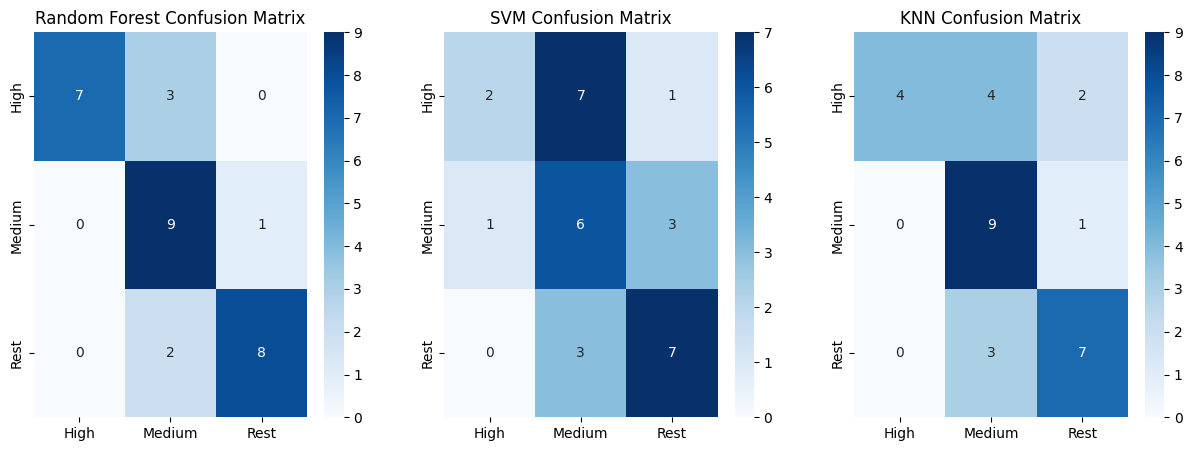

In [ ]:
# Plot 3 Confusion Matrices
cm_rf = confusion_matrix(y_test, rf_preds)
cm_svm = confusion_matrix(y_test, svm_preds)
cm_knn = confusion_matrix(y_test, knn_preds)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axs[0], xticklabels=le.classes_, yticklabels=le.classes_)
axs[0].set_title('Random Forest Confusion Matrix')

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axs[1], xticklabels=le.classes_, yticklabels=le.classes_)
axs[1].set_title('SVM Confusion Matrix')

sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axs[2], xticklabels=le.classes_, yticklabels=le.classes_)
axs[2].set_title('KNN Confusion Matrix')

Text(0.5, 1.0, 'Random Forrest Classifier Confusion Matrix')

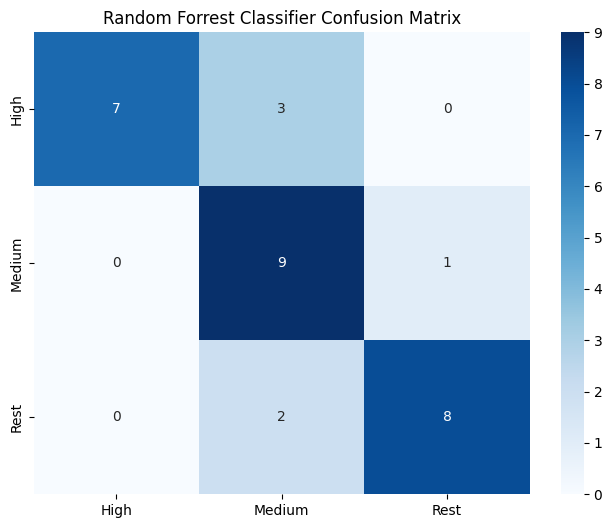

In [ ]:
#@title Single Confusion Matrix
# RF confusion matrix
cm_rf = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Random Forrest Classifier Confusion Matrix')